In [1]:
#test tensorflow
import tensorflow as tf

In [2]:
hello = tf.constant('Hello Tensorflow!')

In [3]:
sess =tf.Session()

In [4]:
print(sess.run(hello))

Hello Tensorflow!


## Bag of words classifier

In [5]:
import pandas as pd
import numpy as np
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Downloading the data

In [6]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [7]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [8]:
annotations.head()

,rev_id,worker_id,attack
0,37675,1362,0.0
1,37675,2408,0.0
2,37675,1493,0.0
3,37675,1439,0.0
4,37675,170,0.0


### Assemble the dataset

In [9]:
#labels a comment as an attack from the majority vote
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [10]:
labels.head()

rev_id
37675    False
44816    False
49851    False
89320    False
93890    False
Name: attack, dtype: bool

In [11]:
#join labels and comments
comments['attack'] = labels

In [12]:
#remove NEWLINE and TAB Tokens
comments['comment'] = comments.comment.str.replace("NEWLINE_TOKEN", " ").str.replace("TAB_TOKEN"," ")

In [13]:
# Split the train and test sets
ratio_train = len(comments[comments['split'] == 'train'])/float(len(comments))
print("Proportion of training data = %.2f" % ratio_train)

ratio_val = len(comments[comments['split'] == 'dev'])/float(len(comments))
print("Proportion of validation data = %.2f" % ratio_val)

ratio_test = len(comments[comments['split'] == 'test'])/float(len(comments))
print("Proportion of test data = %.2f" % ratio_test)

Proportion of training data = 0.60
Proportion of validation data = 0.20
Proportion of test data = 0.20


In [14]:
train_comments = comments[comments['split'] == 'train']
test_comments = comments[comments['split'] == 'test']

In [15]:
train_comments.attack.astype(float).head()

rev_id
37675     0.0
44816     0.0
49851     0.0
93890     0.0
102817    0.0
Name: attack, dtype: float64

## Text classifier

In [16]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features=10000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', LogisticRegression()),    
])

clf = clf.fit(train_comments['comment'], train_comments['attack'])

auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:,1])

print('Test ROC AUC: %.3f' % auc)

Test ROC AUC: 0.957


In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(test_comments['attack'], clf.predict(test_comments['comment']) )

0.94054707049788588

## TF Logistic Regression

In [19]:
# batch size during training
batch_size = 200
max_features = 10000

In [20]:
import nltk
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

In [21]:
# Vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features, ngram_range=(1,2), norm='l2')
sparse_train_comments = tfidf.fit_transform(train_comments.comment)
sparse_test_comments = tfidf.transform(test_comments.comment)


In [22]:
target_train = train_comments.attack.astype(np.float32).as_matrix()
target_test = test_comments.attack.astype(np.float32).as_matrix()

In [23]:
sparse_train_comments.shape

(69526, 10000)

In [24]:
sparse_test_comments.shape

(23178, 10000)

In [25]:
target_train.shape

(69526,)

In [26]:
target_test.shape

(23178,)

In [27]:
# Variables of the Logistic regression model
#weigths
W = tf.Variable(tf.random_normal(shape=[max_features,1]))
# bias
b = tf.Variable(tf.random_normal(shape=[1,1]))

In [28]:
# Initialize placeholders
X = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y = tf.placeholder(shape=[None,1], dtype=tf.float32)

In [29]:
# Declare logistic model (sigmoid loss function)
model_output = tf.add(tf.matmul(X, W), b)

In [30]:
# Declare loss function (cross entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y))

In [31]:
#prediction
prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction, y), tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

In [37]:
# Declare the optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [38]:
#initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [39]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(50000):
    rand_index = np.random.choice(sparse_train_comments.shape[0], size=batch_size)
    rand_x = sparse_train_comments[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]] )
    
    sess.run(train_step, feed_dict={X: rand_x, y: rand_y})
    
    #record every 100 iterations
    if (i+1) % 100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={X: rand_x, y: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={X: sparse_test_comments.todense() , 
                                                   y: np.transpose([target_test] ) })
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={X: rand_x, y: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={X: sparse_test_comments.todense(), 
                                                      y: np.transpose([target_test] ) })
        test_acc.append(test_acc_temp)
        
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.87 (0.89). Train Acc (Test Acc): 0.42 (0.43)
Generation # 1000. Train Loss (Test Loss): 0.75 (0.80). Train Acc (Test Acc): 0.50 (0.50)
Generation # 1500. Train Loss (Test Loss): 0.73 (0.74). Train Acc (Test Acc): 0.58 (0.56)
Generation # 2000. Train Loss (Test Loss): 0.63 (0.68). Train Acc (Test Acc): 0.64 (0.61)
Generation # 2500. Train Loss (Test Loss): 0.67 (0.64). Train Acc (Test Acc): 0.62 (0.65)
Generation # 3000. Train Loss (Test Loss): 0.57 (0.60). Train Acc (Test Acc): 0.72 (0.69)
Generation # 3500. Train Loss (Test Loss): 0.59 (0.58). Train Acc (Test Acc): 0.74 (0.72)
Generation # 4000. Train Loss (Test Loss): 0.49 (0.55). Train Acc (Test Acc): 0.74 (0.74)
Generation # 4500. Train Loss (Test Loss): 0.52 (0.53). Train Acc (Test Acc): 0.77 (0.76)
Generation # 5000. Train Loss (Test Loss): 0.46 (0.52). Train Acc (Test Acc): 0.84 (0.78)
Generation # 5500. Train Loss (Test Loss): 0.53 (0.50). Train Acc (Test Acc): 0.78 (0.79)
Generation 

Generation # 46000. Train Loss (Test Loss): 0.43 (0.41). Train Acc (Test Acc): 0.88 (0.87)
Generation # 46500. Train Loss (Test Loss): 0.44 (0.41). Train Acc (Test Acc): 0.86 (0.87)
Generation # 47000. Train Loss (Test Loss): 0.38 (0.41). Train Acc (Test Acc): 0.88 (0.87)
Generation # 47500. Train Loss (Test Loss): 0.31 (0.41). Train Acc (Test Acc): 0.90 (0.87)
Generation # 48000. Train Loss (Test Loss): 0.39 (0.41). Train Acc (Test Acc): 0.88 (0.87)
Generation # 48500. Train Loss (Test Loss): 0.35 (0.41). Train Acc (Test Acc): 0.89 (0.87)
Generation # 49000. Train Loss (Test Loss): 0.35 (0.41). Train Acc (Test Acc): 0.90 (0.87)
Generation # 49500. Train Loss (Test Loss): 0.47 (0.41). Train Acc (Test Acc): 0.86 (0.87)
Generation # 50000. Train Loss (Test Loss): 0.38 (0.41). Train Acc (Test Acc): 0.88 (0.87)


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

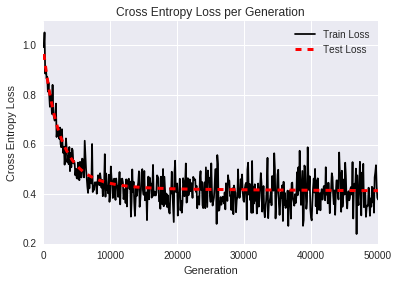

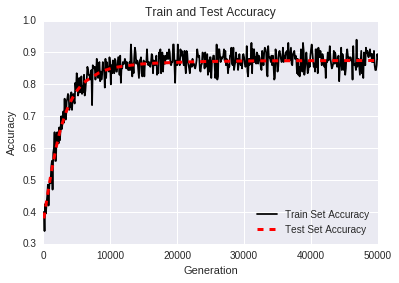

In [41]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=3)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=3)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()